# **No Camera Man Left Behind**
## CIS 5810 Group Project
By Sindhura Mente, Sriya Reddi, Jeffrey Li, Amar Mohanty <br>
December 15, 2022

# Project Summary

In this project, we address a universal issue in taking group pictures: leaving out the photographer. Having access to a source image of only the photographer and a target image of the rest of the group, we propose a program that can incorporate both parties into one realistic final output using open-source software, namely NumPy, OpenCV, and PyTorch. The image processing pipeline involves three major steps: (1) image segmentation of person(s), (2) information extraction from the source image, and (3) gradient domain blending. From qualitative tests, our program works well on images with people standing in front of a solid background and with people standing next to each other on the horizontal axis. The final product rivals the results manually produced using Adobe Photoshop software. The program performs suboptimally on images with complex backgrounds, with people standing at different locations in the foreground, and images taken at different angles. Future work can be done to improve the robustness of our program and to combat more edge cases.

# Import & Setting Up

## Import/Install Packages

In [ ]:
# install packages

!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 3.2 MB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
     |████████████████████████████████| 376 kB 51.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e7d02b6ec671369e5be6f8c682463d70d5a4d3f9a9765d36d744b366c45f9ba4
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=929adcc371d3189e8e85087a9e1be8cd19859b6225db20c0bb124423f52a8fb6
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
# import packages

import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from skimage.measure import label, regionprops, find_contours

from google.colab import drive

## Checking for GPU Access

In [ ]:
if torch.cuda.is_available():
    print('We have a GPU!')
    DEVICE = 'cuda'
else:
    print('Program will not work. Please Change to GPU')
    DEVICE = 'cpu'

We have a GPU!


## Setting Up Directory [TODO]

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TODO: Mount your Google Drive

In [ ]:
cd /content/drive/MyDrive/CIS-5810-Final-Project/Submission/Notebook

/content/drive/MyDrive/CIS-5810-Final-Project/Submission/Notebook


# Define Source and Target Image [TODO]

In [ ]:
# TODO: Change the file directory to whichever source or target image you want to use.
sourcePath = 'Images/Solid/source.jpg'
targetPath = 'Images/Solid/target.jpg'

Text(0.5, 1.0, 'Target Image')

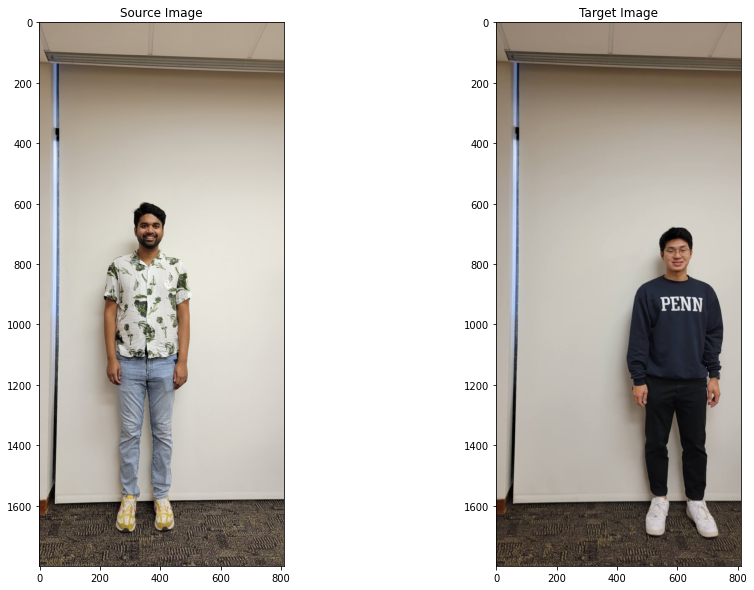

In [ ]:
# Read Images
dis_src = cv2.imread(sourcePath)
dis_tar = cv2.imread(targetPath)

# Display Images
_, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(cv2.cvtColor(dis_src, cv2.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv2.cvtColor(dis_tar, cv2.COLOR_BGR2RGB))
ax[1].set_title("Target Image")

# Load Deep Learning Model

In [ ]:
model = smp.Unet(encoder_name='efficientnet-b3',
  in_channels=3, classes=1, activation=None).to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/CIS-5810-Final-Project/Work/Main_Environment/model.pt"))
model.eval()
print("Model Loaded")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Model Loaded


# Load Images and Generate Masks

Text(0.5, 1.0, 'Target Mask')

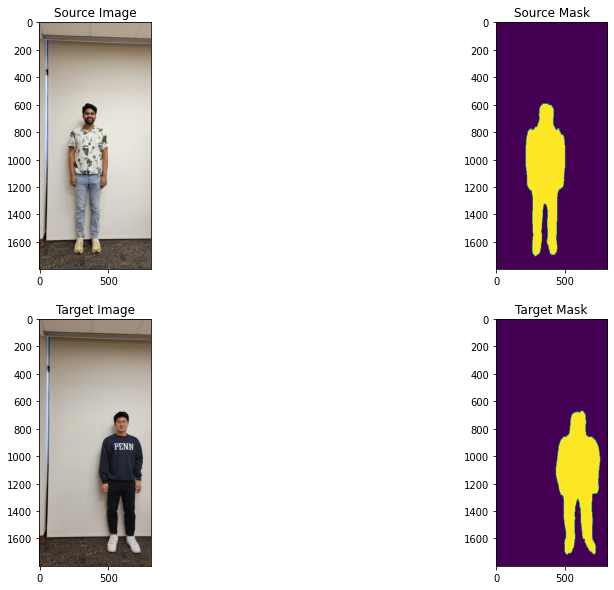

In [ ]:
# Pull Source and Target Image
sourceImage = np.array(Image.open(sourcePath).convert("RGB"), dtype=np.float32) / 255
targetImage = np.array(Image.open(targetPath).convert("RGB"), dtype=np.float32) / 255

# Store Original Shapes
origSourceH, origSourceW = sourceImage.shape[:2]
origTargetH, origTargetW = targetImage.shape[:2]

# Transform Images
val_transform = A.Compose(
    [
        A.Resize(height=192, width=256),
        ToTensorV2(),
    ],
)

# Transform Images
sourceImageTf = val_transform(image = sourceImage)['image'].to('cuda').unsqueeze(0)
targetImageTf = val_transform(image = targetImage)['image'].to('cuda').unsqueeze(0)

# Generate Masks
output = ((torch.sigmoid(model(sourceImageTf))) >0.5).float()
sourceMaskTf = output.cpu()[0][0].numpy()
output = ((torch.sigmoid(model(targetImageTf))) >0.5).float()
targetMaskTf = output.cpu()[0][0].numpy()

# Resize Back to Original Size
sourceMask = cv2.resize(sourceMaskTf, (origSourceW, origSourceH), interpolation = cv2.INTER_AREA)*255
targetMask = cv2.resize(targetMaskTf, (origTargetW, origTargetH), interpolation = cv2.INTER_AREA)*255

# Plot Target and Source Images and Masks
_, ax = plt.subplots(2,2, figsize=(15,10))
ax[0][0].imshow(sourceImage)
ax[0][0].set_title("Source Image")
ax[0][1].imshow(sourceMask)
ax[0][1].set_title("Source Mask")
ax[1][0].imshow(targetImage)
ax[1][0].set_title("Target Image")
ax[1][1].imshow(targetMask)
ax[1][1].set_title("Target Mask")

# Bounding Boxes (Definition of Source Placement and Source Crop)

In [ ]:
""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

def parse_mask(mask):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    return mask

## Bounding Box for Source Image and Calculation of Height and Width 

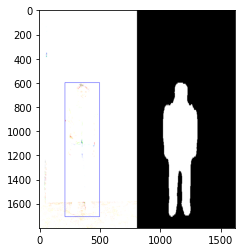

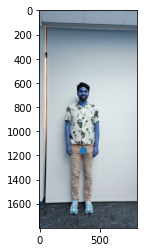

In [ ]:

""" Load the source """
src = sourcePath #source path goes here
src_mask = sourceMask # source mask path goes here

""" Read source image and source mask """
x = cv2.imread(src, cv2.IMREAD_COLOR)
y = src_mask

""" Detecting bounding boxes """
bboxes = mask_to_bbox(y)

""" marking bounding box on image """
bbox = bboxes[0]
x = cv2.rectangle(x, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

""" Displaying the image """
src_display_img = np.concatenate([x, parse_mask(y)], axis=1)
plt.imshow(cv2.cvtColor(src_display_img, cv2.COLOR_BGR2RGB))
plt.show()

'''Calulating height and width of source & their midpoint coordinates'''
height = bbox[1]-bbox[3]
width = bbox[2]-bbox[0]
midHeight = height // 2
midWidth = width // 2

plt.imshow(cv2.imread(src, cv2.IMREAD_COLOR))

plt.scatter(x = [bbox[0] + midWidth], y = [bbox[3] + midHeight])


## Crop Source Image to Bounding Box

Text(0.5, 1.0, 'Cropped Source Mask')

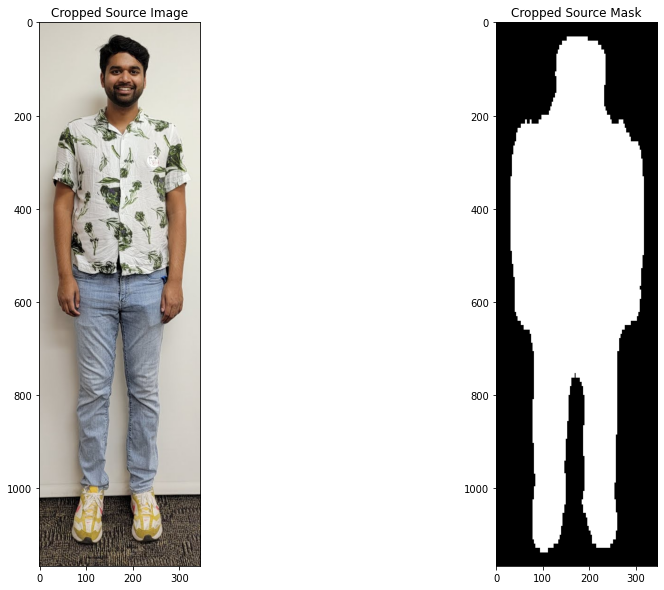

In [ ]:
#Cropping source Image and its Mask using the Bounding Box

img = cv2.imread(src)

mask = src_mask
X, Y, W, H = bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]

# Adding buffer spacing in cropped mask image
cropped_src = img[Y-30:Y+H+30, X-30:X+W+30]
cropped_src_mask = mask[Y-30:Y+H+30, X-30:X+W+30]

# Cropped Source and Mask
_, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))
ax[0].set_title("Cropped Source Image")
ax[1].imshow(cv2.cvtColor(cropped_src_mask, cv2.COLOR_BGR2RGB))
ax[1].set_title("Cropped Source Mask")

## Provide Pixel Coordinates in Target Image for Placement of Source Image Person

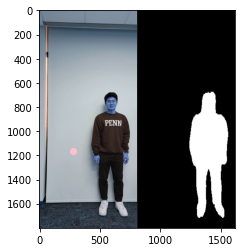

In [ ]:
""" Load the target image and mask """
tgt = targetPath # target image path goes here
tgt_mask = targetMask #target mask path goes here

""" Read image and mask """
x = cv2.imread(tgt, cv2.IMREAD_COLOR)
#y = cv2.imread(tgt_mask, cv2.IMREAD_GRAYSCALE)
y = tgt_mask

""" Detecting bounding boxes """
bboxes = mask_to_bbox(y)

""" marking bounding box on image """
bbox = bboxes[0]
x = cv2.rectangle(x, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

""" Displaying the image """
tgt_display_img = np.concatenate([x, parse_mask(y)], axis=1)
plt.imshow(cv2.cvtColor(tgt_display_img, cv2.COLOR_BGR2RGB))


bottom_right = (bbox[0], bbox[3])
padding = 9
center = ((bottom_right[0] - midWidth - padding), (bottom_right[1] + midHeight))
plt.imshow(cv2.imread(tgt, cv2.IMREAD_COLOR))

plt.scatter(x = center[0], y = center[1], color='pink')

center -> (x, y), cropped_src -> array, cropped_src_mask -> array inputs to next part of pipeline

# Seamless Cloning 

In [ ]:
# initialize target image 
target = cv2.imread(targetPath)

# minor changes
# convert to three channels
cropped_src_mask = cv2.cvtColor(cropped_src_mask, cv2.COLOR_GRAY2RGB) 

# convert to int 2d matrix
cropped_src_mask = cropped_src_mask.astype(np.uint8)

In [ ]:
# check shapes
print('source size: ', cropped_src.shape)
print('source mask size: ', cropped_src_mask.shape)
print('target size: ', target.shape)

source size:  (1167, 346, 3)
source mask size:  (1167, 346, 3)
target size:  (1800, 810, 3)


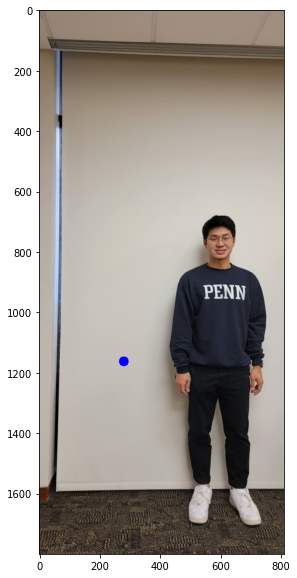

In [ ]:
# locate center at target image
target_dot = target.copy()
target_dot = cv2.circle(target_dot, center, radius=1, color=(255, 0, 0), thickness=30)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_dot, cv2.COLOR_BGR2RGB))

In [ ]:
im = cv2.cvtColor(cropped_src_mask, cv2.COLOR_BGR2GRAY)
_, im_t = cv2.threshold(im, 160, 255, cv2.THRESH_BINARY) # binarize
contours, _ = cv2.findContours(im_t, 1, 2)

# make copy 
gray_cropped_mask_rect = cropped_src_mask.copy()
x, y, w, h = cv2.boundingRect(contours[0])

# create rectanglular white box over image
gray_cropped_mask_rect = cv2.rectangle(gray_cropped_mask_rect,(x,y), (x+w,y+h), (255,255,255), -1) 

# change black pixels to gray
gray_cropped_mask_rect[np.where((gray_cropped_mask_rect==[0,0,0]).all(axis=2))] = (128,128,128)
# cropped_src_mask[np.where((cropped_src_mask==[0,0,0]).all(axis=2))] = (128,128,128)

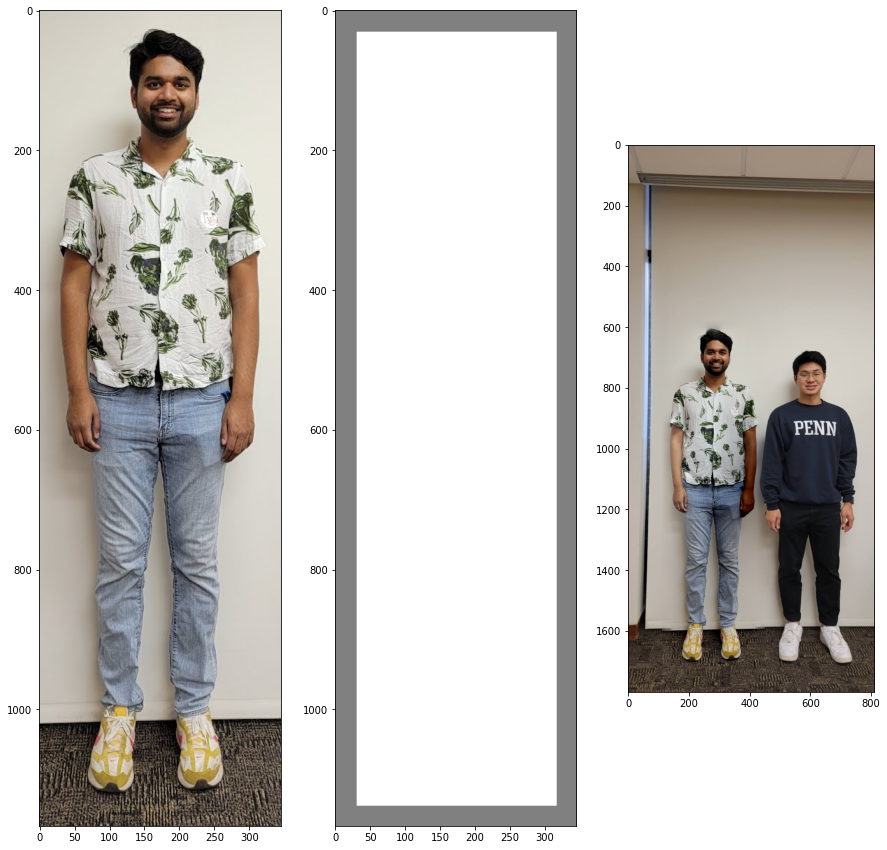

In [ ]:
output = cv2.seamlessClone(cropped_src, target, gray_cropped_mask_rect, center, cv2.NORMAL_CLONE)

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cropped_src, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gray_cropped_mask_rect, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

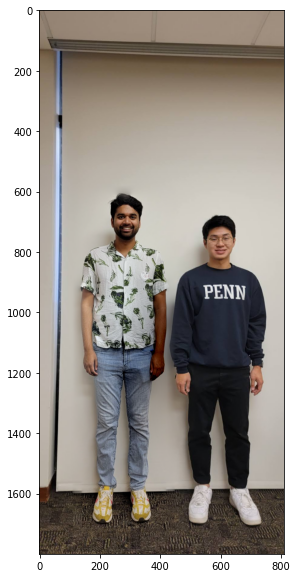

In [ ]:
# display output image

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

# Compare with Ground Truth [TODO]

We used Adobe Photoshop software to stitch the source image onto the target image in the beginning of our project. We use this as our ground truth and we compare it with the output from the seamless cloning method.

In [ ]:
# TODO: If you have a ground truth image (real image or Photoshopped Image), please 
# add it here. If not, please ignore this section. There is only one Ground Truth 
# image in our Images file, and it is Images/Solid/groundtruth.jpeg

ground_truth = cv2.imread('Images/Solid/groundtruth.jpeg')

Text(0.5, 1.0, 'Adobe Photoshop Output')

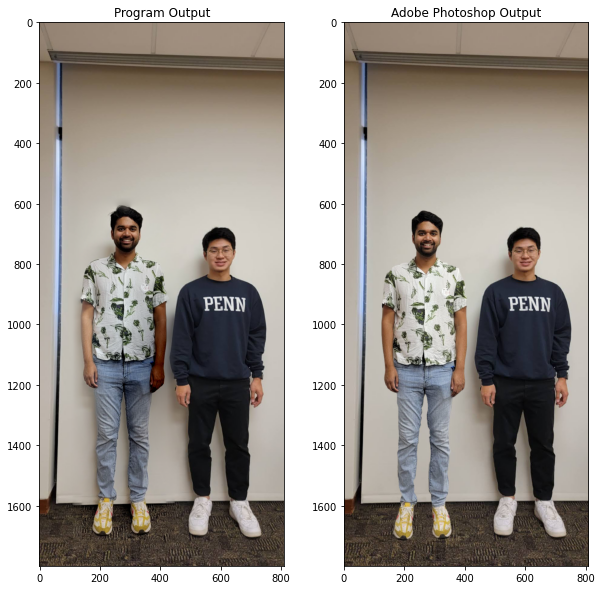

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Program Output")
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
plt.title("Adobe Photoshop Output")

# Save Output [TODO]

In [ ]:
# TODO: Save your output. Be sure to change the file name!
# cv2.imwrite('Results/xxxxxxxxxxxxxxxxxxxxxxx.jpg', output)